In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm import tqdm
from syspy.skims import skims
from quetzal.model import stepmodel
from quetzal.engine import engine
from quetzal.io import excel

# Preparation of the LoS tables
## Corrects footpaths in the LoS table
## Needs PT LoS table and footpaths

In [3]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [10]:
sm = stepmodel.read_zippedpickles(model_path + 'de_pt_los')
try:
    ae = stepmodel.read_json(model_path + 'de_pt_access_egress')
    z = stepmodel.read_json(model_path + 'de_zones')
except FileNotFoundError:
    ae = stepmodel.read_json(model_path.replace(scenario, 'base') + 'de_pt_access_egress')
    z = stepmodel.read_json(model_path.replace(scenario, 'base') + 'de_zones')
ae.zones = z.zones

In [6]:
# make sure that time is in hours
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 3600

In [7]:
# Drop walking links that use access-egress links
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type']!='walk']

In [ ]:
# Use saved non-motorised paths, if they exist from a previous run
if os.path.exists(model_path + 'de_pt_los_non-motor/') and not params['cycling']['highways_min_popdens'] > 0:
    w = stepmodel.read_json(model_path + 'de_pt_los_non-motor')
    # Align the OD sets
    for df in [w.pt_los, sm.pt_los]:
        df['od'] = list(df[['origin', 'destination']].values)
        df['od'] = df['od'].apply(tuple)
    # Only continue if OD sets match
    if len(set(sm.pt_los['od']) - set(w.pt_los['od'])) == 0:
        w.pt_los = w.pt_los.loc[w.pt_los['od'].isin(sm.pt_los['od'])]
        # Append non-motorised rows
        sm.pt_los = pd.concat([sm.pt_los, w.pt_los.loc[w.pt_los['route_type']=='walk']]).reset_index(drop=True)
        sm.pt_los.drop('od', axis=1, inplace=True)
        print('Added walking paths from previous run')
        sm.to_zippedpickles(model_path + 'de_pt_los', only_attributes=['pt_los'])
        raise KeyboardInterrupt # break automation

In [31]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,...,"(business_no_car, probability)","(business_car, probability)","(education_no_car, probability)","(education_car, probability)","(buy/execute_no_car, probability)","(buy/execute_car, probability)","(leisure_no_car, probability)","(leisure_car, probability)","(accompany_no_car, probability)","(accompany_car, probability)"
39189,DEA1E_4,DEA36_0,"(coach, bus)","[bus_739499, bus_739501, bus_739503, bus_96595...",4.0,78669,1391,386.0,4260,5177.0,...,0.066402,0.007049,0.285964,0.132874,0.301563,0.00315,0.185424,0.021407,0.018941,0.001561


## Compute mean distances
Based on census data: mean population-weighted distance from origin centroid to every population cluster in the destination zone

In [15]:
# Build zone-connecting footpaths
foot = engine.ntlegs_from_centroids_and_nodes(
    ae.centroids,
    ae.centroids,
    short_leg_speed=params['pt_access']['speed_bicycle'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=params['access-egress_links']['n_bicycle_between_zones'],
    coordinates_unit=ae.coordinates_unit)
foot = foot.loc[foot['distance']<=params['access-egress_links']['bicycle_max_dist']]
foot = foot.loc[foot['distance']!=0]
foot.drop_duplicates(['a', 'b', 'time'], inplace=True)
print(len(foot))
foot.sample()

22196


,a,b,rank,distance,geometry,direction,speed_factor,short_leg_speed,long_leg_speed,speed,time
20938,DE404_0,DE40A_4,9,32918.057375,"LINESTRING (13.05358 52.400355, 13.173369 52.6...",access,9.071667,15,15,15.0,7900.33377


In [16]:
# Build all columns of LoS table
foot = foot[['a', 'b', 'distance']]
if 'path' in sm.pt_los.columns:
    foot['index'] = foot.index
    foot['path'] = [(a,i,b) for a,i,b in zip(foot['a'], foot.index, foot['b'])]
    foot.drop('index', axis=1, inplace=True)
foot = foot.rename(columns={'a': 'origin', 'b': 'destination', 'distance': 'length'})
foot['link_path'] = [[] for _ in range(len(foot))]
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
for col in ['ntransfers', 'access_time', 'footpath_time',
            'in_vehicle_time', 'waiting_time', 'boarding_time', 'time'
           ] + [s+'_price' for s in segments]:
    if col in sm.pt_los.columns:
        foot[col] = 0
foot['route_types'] = [('walk',) for _ in range(len(foot))]
foot['route_type'] = 'walk'

In [17]:
# Clean
foot = foot.loc[~(~(foot['origin'].str.startswith('DE')) |
                  ~(foot['origin'].str.startswith('DE')) |
                  (foot['origin']==foot['destination']))]
foot.drop_duplicates(subset=['origin', 'destination'], inplace=True)
foot.reset_index(drop=True, inplace=True)
foot.shape

(22193, 25)

In [18]:
foot.sample()

,origin,destination,length,path,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,...,education_no_car_price,education_car_price,buy/execute_no_car_price,buy/execute_car_price,leisure_no_car_price,leisure_car_price,accompany_no_car_price,accompany_car_price,route_types,route_type
20520,DE117_0,DE127_2,21454.593056,"(DE117_0, 40088, DE127_2)",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(walk,)",walk


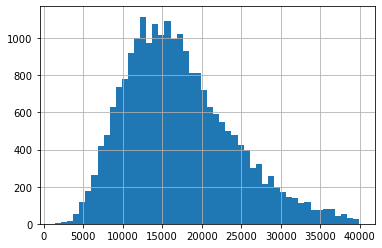

In [19]:
# Centroid distances
if manual: foot['length'].hist(bins=50)

<AxesSubplot:>

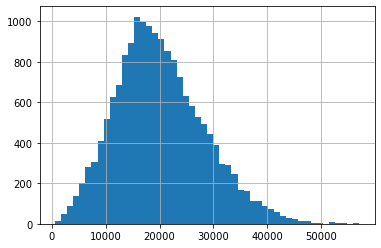

In [17]:
if False:
    # Load census data: Zensus 2011 - Einwohnerzahl je Hektar
    # Copyright: © Statistisches Bundesamt, Wiesbaden 2015
    # (im Auftrag der Herausgebergemeinschaft)
    # Vervielfältigung und Verbreitung, auch auszugsweise, mit Quellenangabe gestattet
    if os.path.isfile(input_path + 'Zensus_2011.geojson'):
        pop = gpd.read_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')
    else:
        print('No file with geometries found')
        import shapely.speedups
        pop = pd.read_csv(input_path + 'Zensus_2011.csv', sep=';')
        # Restrict to entries that hold information
        pop = pop.loc[pop['Einwohner']!=-1]
        pop = gpd.GeoDataFrame(pop[['Einwohner']],
                              geometry=gpd.points_from_xy(pop['x_mp_100m'], pop['y_mp_100m']))
        pop.crs = 3035
        pop.to_crs(sm.epsg, inplace=True)
        pop['FID'] = np.nan
        z = stepmodel.read_json(model_path + 'de_zones')
        shapely.speedups.enable
        for _, zone in tqdm(z.zones.iterrows(), total=z.zones.shape[0]):
            pop.loc[pop['geometry'].within(zone['geometry']), 'FID'] = zone['FID']
        pop.to_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')

    # Calculate mean population-weighted distances
    # from the origin centroid to all points in the destination zone
    for ind, row in tqdm(foot.iterrows(), total=len(foot.index)):
        o = ae.centroids.loc[row['origin'], 'geometry']
        zone = pop.loc[pop['FID']==row['destination']]
        weighted_dist = [skims.get_distance_from_lon_lat_in_m(
            o.coords[0][0], o.coords[0][1], p['geometry'].coords[0][0], p['geometry'].coords[0][1])
                         * p['Einwohner'] for _, p in zone.iterrows()]
        foot.loc[ind, 'length'] = sum(weighted_dist) / zone['Einwohner'].sum()

    if manual: foot['length'].hist(bins=50)

In [22]:
# Generate time in hours
foot['length'] = foot['length'].fillna(foot['length'].mean())
foot['time'] = foot['length'] / (params['cycling']['speed'] * 1000)
foot['time'] = foot['time'].clip(lower=params['cycling']['min_time']) # add a minimum
# Apply cycling highways policy
min_popdens = params['cycling']['highways_min_popdens']
if min_popdens > 0:
    conn_zones = ae.zones.loc[(ae.zones['population'] / ae.zones['area']) >= min_popdens].index
    foot.loc[(foot['origin'].isin(conn_zones)) & (foot['destination'].isin(conn_zones)),
             'time'] *= 1 + params['cycling']['highways_speed_increase']
if 'footpath_time' in sm.pt_los.columns:
    foot['footpath_time'] = foot['time']

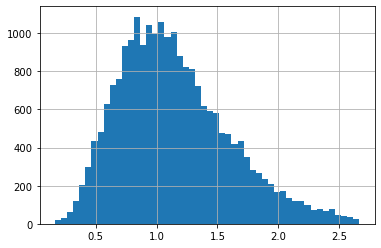

In [23]:
if manual: (foot['time']).hist(bins=50) # in h

## Save

In [39]:
# Make DataFrame lighter
cols = ['length']
foot[cols] = foot[cols].astype(int)

In [40]:
# Add to LoS table
# Align the OD sets
for df in [foot, sm.pt_los]:
    df['od'] = list(df[['origin', 'destination']].values)
    df['od'] = df['od'].apply(tuple)
foot = foot.loc[foot['od'].isin(sm.pt_los['od'])]
# Append non-motorised rows
sm.pt_los = pd.concat([sm.pt_los, foot]).reset_index(drop=True)
sm.pt_los.drop('od', axis=1, inplace=True)

In [41]:
# Drop columns from previous logit model runs
sm.pt_los.drop([col for col in sm.pt_los.columns if str(col).startswith('(')
               ] + [s+'_time' for s in segments],
               axis=1, inplace=True, errors='ignore')

In [42]:
sm.pt_los.loc[sm.pt_los['route_type']=='walk'].sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,...,education_no_car_price,education_car_price,buy/execute_no_car_price,buy/execute_car_price,leisure_no_car_price,leisure_car_price,accompany_no_car_price,accompany_car_price,path,mode_utility
79195,DE723_5,DE723_6,"(walk,)",[],0.0,9046,0,0.532123,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(DE723_5, 10027, DE723_6)",NaN


In [43]:
sm.to_zippedpickles(model_path + 'de_pt_los', only_attributes=['pt_los'])

pt_los: 100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 37.10it/s]


In [25]:
# Save only the walking part
if manual:
    sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type']=='walk']
    sm.to_json(model_path + 'de_pt_los_non-motor',
               only_attributes=['pt_los'],
               encoding='utf-8')

to_hdf(overwriting): 100%|███████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 17.93it/s]
